In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

import glob
import sys
import os
from collections import OrderedDict

import csv

sys.path.insert(0, "../hcr-ff/")
from plot_utils import *
from genome_utils import *

In [2]:
# Guide score files
F1R1_fn = '../data/FASTQ/FADS1_rep8detailed.txt'
F1R2_fn = '../data/FASTQ/FADS1_rep9detailed.txt'

F2R1_fn = '../data/FASTQ/FADS2_rep8detailed.txt'
F2R2_fn = '../data/FASTQ/FADS2_rep11detailed.txt'

F3R1_fn = '../data/FASTQ/FADS3_rep7detailed.txt'
F3R2_fn = '../data/FASTQ/FADS3_rep8detailed.txt'

FnR1_fn = '../data/FASTQ/FEN1_rep11detailed.txt'
FnR2_fn = '../data/FASTQ/FEN1_rep12detailed.txt'

fn_list = [F1R1_fn,F1R2_fn,F2R1_fn,F2R2_fn,
           F3R1_fn,F3R2_fn,FnR1_fn,FnR2_fn]

exp_ids = ['F1R1','F1R2','F2R1','F2R2',
           'F3R1','F3R2','FnR1','FnR2']

fullinfo= [("FADS1",1), ("FADS1",2), ("FADS2",1), ("FADS2",2), 
           ("FADS3",1), ("FADS3",2), ("FEN1",1), ("FEN1",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [3]:
# Peak BED files
# MAINTAIN ORDER (see exp_ids variable above)
F1R1_bed= '../data/FADS1_rep8__fixPeaks.bed'
F1R2_bed= '../data/FADS1_rep9__fixPeaks.bed'

F2R1_bed= '../data/FADS2_rep8__rescore_fixPeaks.bed'
F2R2_bed= '../data/FADS2_rep11__rescore_fixPeaks.bed'

F3R1_bed= '../data/FADS3_rep7__rescore_fixPeaks.bed'
F3R2_bed= '../data/FADS3_rep8__rescore_fixPeaks.bed'

FnR1_bed= '../data/FEN1_rep11__rescore_fixPeaks.bed'
FnR2_bed= '../data/FEN1_rep12__rescore_fixPeaks.bed'

exp_beds= [F1R1_bed, F1R2_bed, F2R1_bed, F2R2_bed, 
           F3R1_bed, F3R2_bed, FnR1_bed, FnR2_bed]

K27_bed = '../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed'
DHS_bed = '../data/DNASE_peaks_replicated.bed'

extra_beds = [ K27_bed, DHS_bed ]
extra_tags = [ 'k27', 'DHS' ]

In [4]:
gff = pd.read_table('../data/FADS_locus.gff')

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
gff

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,geneID
0,ENST00000542506.5,chr11,-,61802312,61815291,61802410,61813305,12,"61802312,61802800,61803031,61803362,61803669,6...","61802462,61802926,61803111,61803459,61803767,6...",FADS1
1,ENST00000257261.10,chr11,+,61816255,61867354,61816285,61865689,12,"61816255,61837777,61840333,61840623,61848158,6...","61816426,61837888,61840531,61840725,61848284,6...",FADS2
2,ENST00000305885.3,chr11,+,61792910,61797238,61795361,61796504,2,"61792910,61795340","61793028,61797238",FEN1
3,ENST00000278829.7,chr11,-,61873525,61891545,61873813,61891381,12,"61873525,61875850,61876110,61876358,61876865,6...","61873865,61875976,61876190,61876455,61876963,6...",FADS3


In [6]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

In [8]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [9]:
# Get experimental peaks
## Read in files
test_peaks = [ pd.read_table(
                 fn,sep='\t',header=None,
                 names=['chr','start','end','hdr','pass','strand']
               ) 
               for fn in exp_beds ]
## Figure out which chromosomes were tested
tested_chr = pd.concat( test_peaks, axis=0 )['chr'].unique()
## Filter out non-significant peaks
test_peaks = [ merge_bed(
                   df.loc[ df['pass'] == True, ('chr','start','end') ].copy()
               )
               for df in test_peaks ]
## Filter out tiny peaks
test_peaks = [ df[ (df['end'] - df['start']) > 100 ]
               for df in test_peaks ]

print("Experimental track count: {}".format(len(test_peaks)))

# Add on extra features from ENCODE
## Read in files
extra_feat = [ pd.read_table(fn,sep='\t',header=None,
                             names=['chr','start','end'],usecols=[0,1,2]) 
               for fn in extra_beds ]
## Filter out un-tested chromosomes for speed
chr_filters = [ np.vstack([feat['chr'] == chrom for chrom in tested_chr ]).any(axis=0) 
                for feat in extra_feat ]

# Combine
[ test_peaks.append( feat.loc[ chr_filter ,:] ) for feat, chr_filter in zip(extra_feat, chr_filters) ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print("Total track count: {}".format(len(test_peaks)))
for exp_id, peaks_idx in zip(exp_ids+extra_tags,range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


Experimental track count: 8
Total track count: 10


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: read_table is deprecated, use read_csv instead.


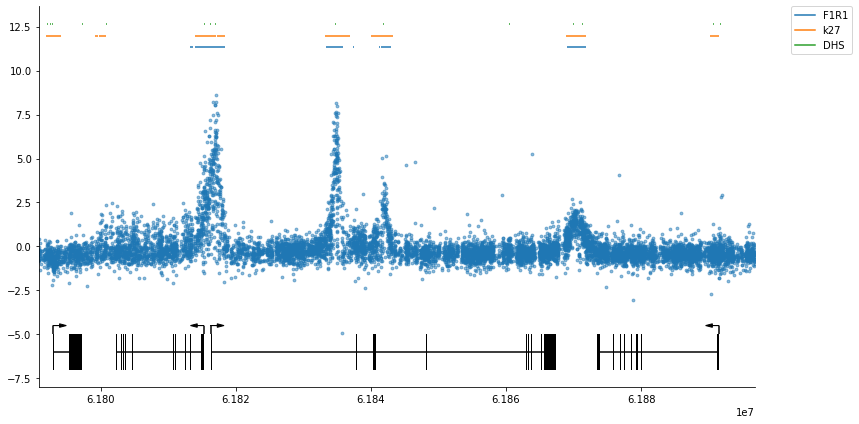

In [10]:
fig_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff)

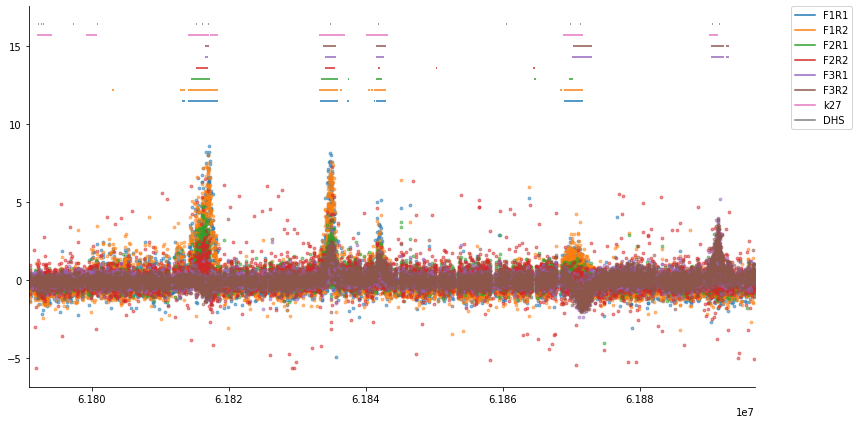

In [11]:
fig_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


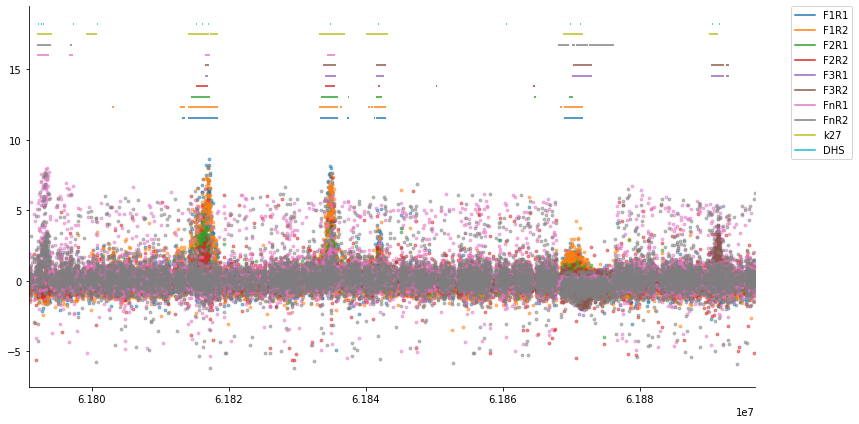

In [12]:
fig_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'])


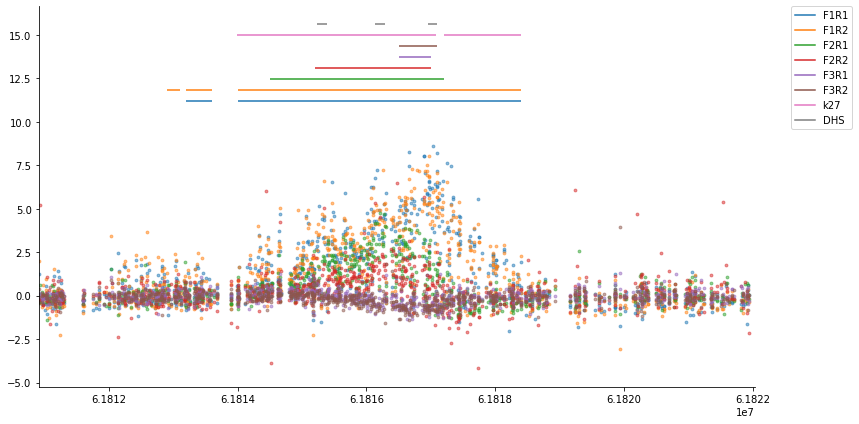

In [13]:
fig_h = plot_hff_cutsites(np.array([[61810908,61822034]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


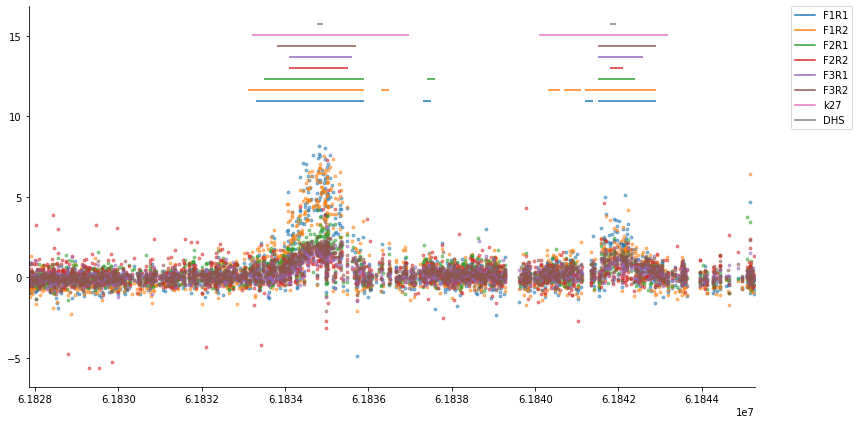

In [14]:
fig_h = plot_hff_cutsites(np.array([[61827852,61845270]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


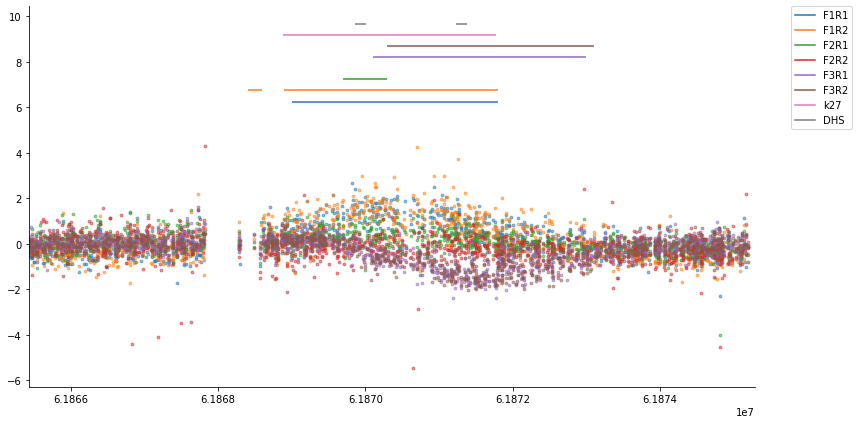

In [15]:
fig_h = plot_hff_cutsites(np.array([[61865430,61875290]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


FADS1
1
FADS2
0
FADS3
6
FEN1
2


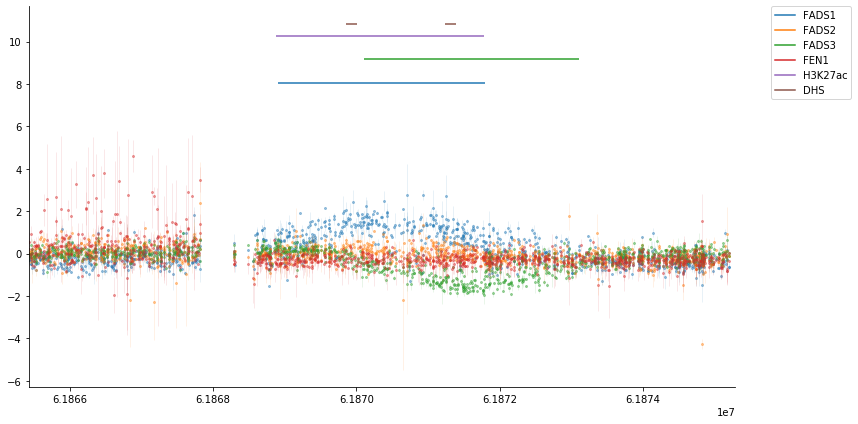

In [16]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61865430,61875290]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'])
fig_h.savefig('FADS_locus__61865430_61875290__all.pdf')

FADS1
1
FADS2
0
FADS3
6


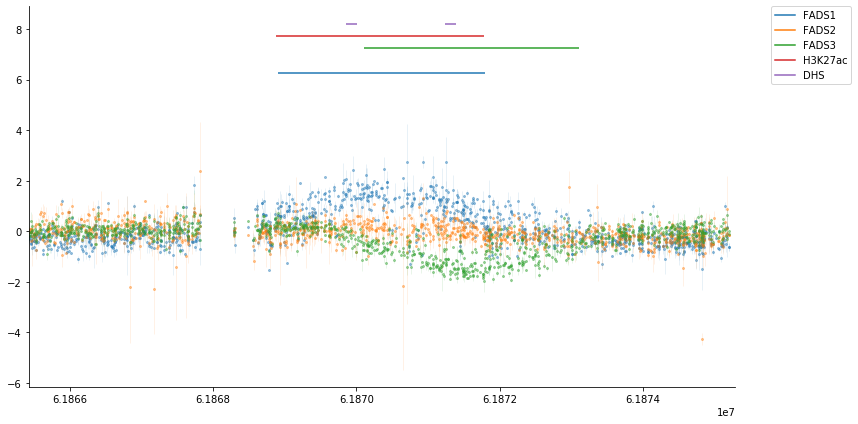

In [17]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61865430,61875290]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61865430_61875290__noFEN1.pdf')

FADS1
16
FADS2
11
FADS3
27


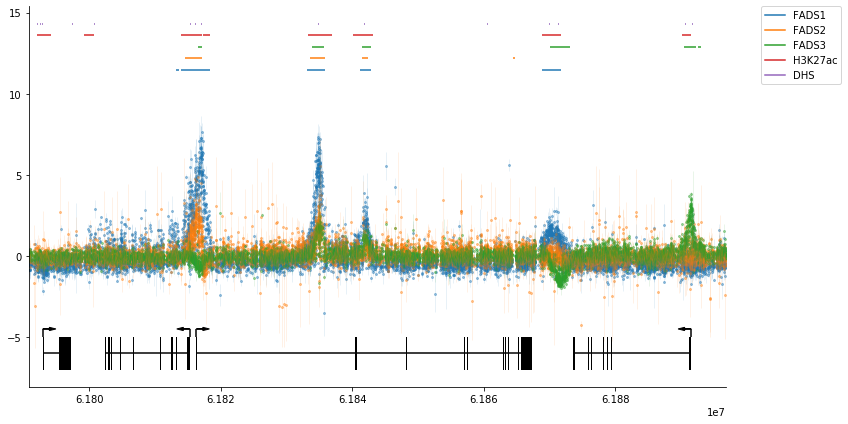

In [18]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])

draw_genes_from_gff(ax_h, gff)


FADS1
16
FADS2
11
FADS3
27
FEN1
46


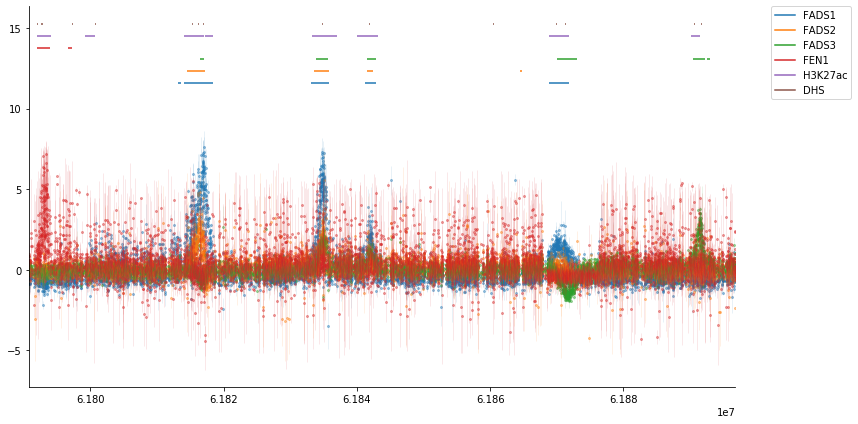

In [19]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'])


FADS1
16


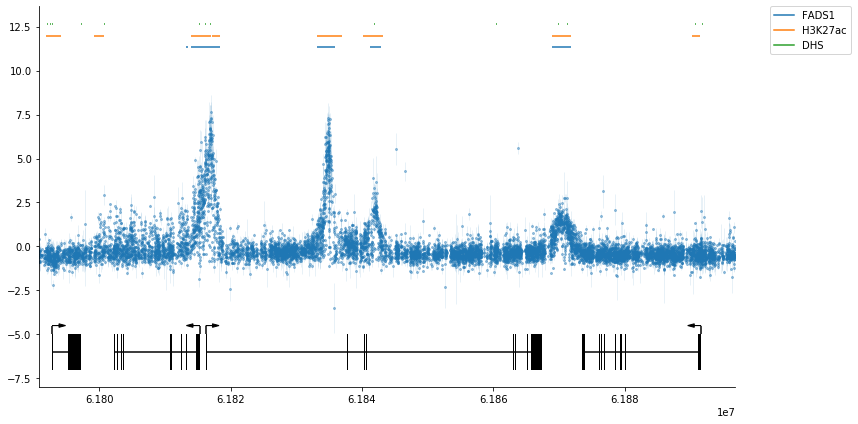

In [20]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','k27','DHS'])

draw_genes_from_gff(ax_h, gff)

FADS2
11


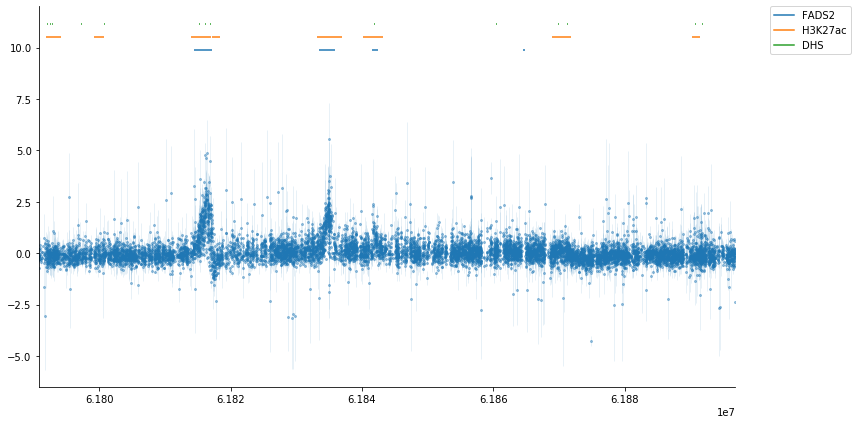

In [21]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F2R1','F2R2','k27','DHS'])


FADS3
27


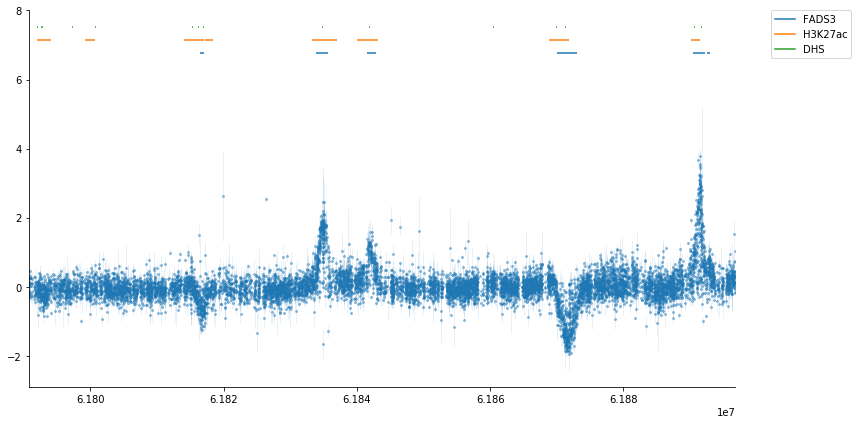

In [22]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F3R1','F3R2','k27','DHS'])


FEN1
46


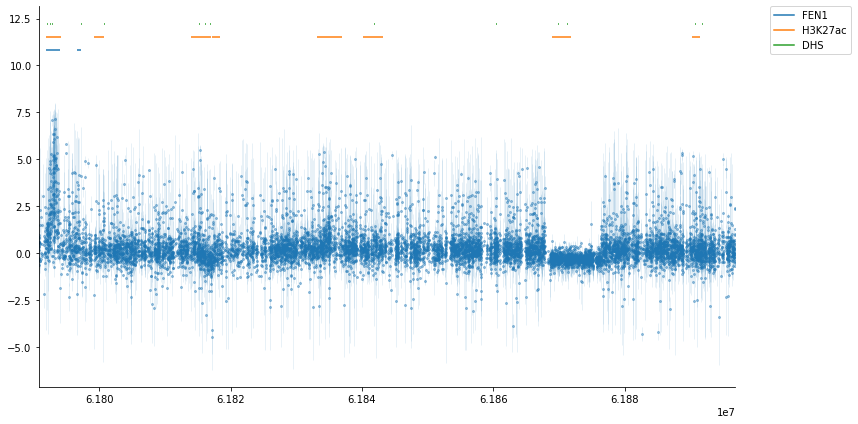

In [23]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['FnR1','FnR2','k27','DHS'])


FEN1
16


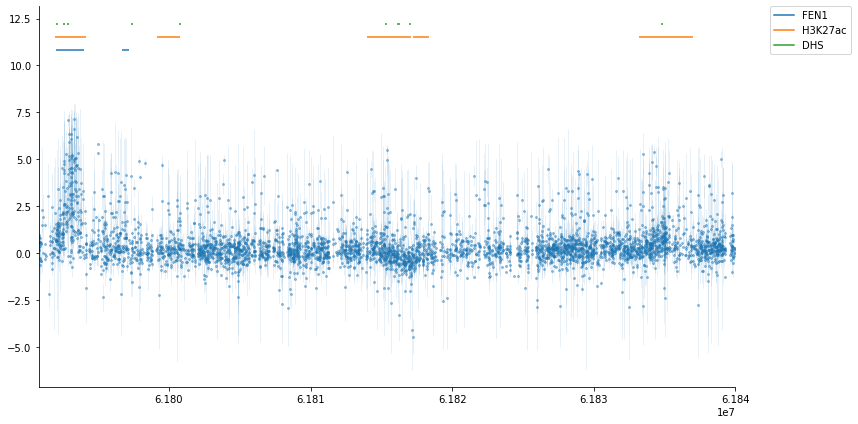

In [24]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61790805,61840000]]), 
                  data, test_peaks, plot_ids=['FnR1','FnR2','k27','DHS'])


FADS1
1
FADS2
1
FADS3
1


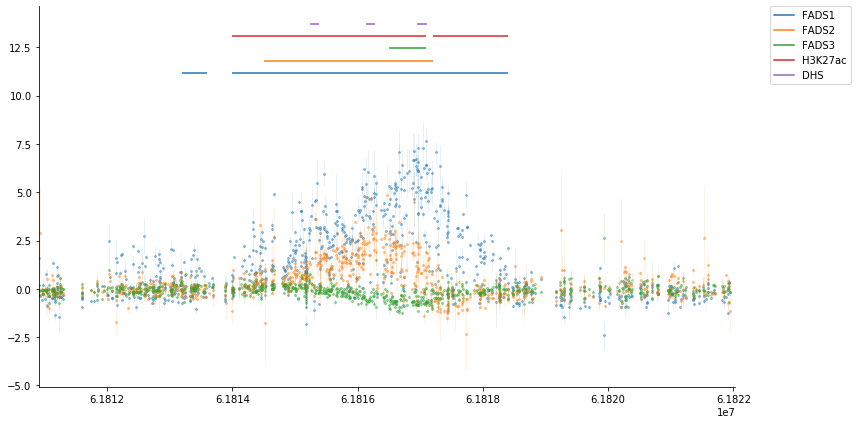

In [25]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61810908,61822034]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61810908_61822034__noFEN1.pdf')

FADS1
5
FADS2
3
FADS3
8


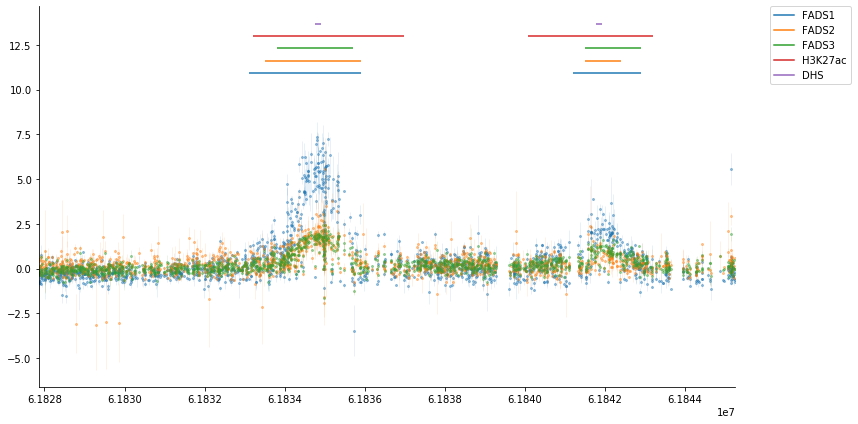

In [26]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61827852,61845270]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61827852_61845270__noFEN1.pdf')

# Connection diagram

In [27]:
txn_starts = extract_txn_starts(gff)

In [28]:
all_locus_peaks = get_replicating_peaks(test_peaks)

In [29]:
# FADS1
FADS1_total_scores = get_peak_strengths(F1R1_bed, F1R2_bed)

# FADS2
FADS2_total_scores = get_peak_strengths(F2R1_bed, F2R2_bed)

# FADS3
FADS3_total_scores = get_peak_strengths(F3R1_bed, F3R2_bed)

# FEN1
FEN1_total_scores  = get_peak_strengths(FnR1_bed, FnR2_bed)



../hcr-ff/plot_utils.py:310: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  for fn in argv ]


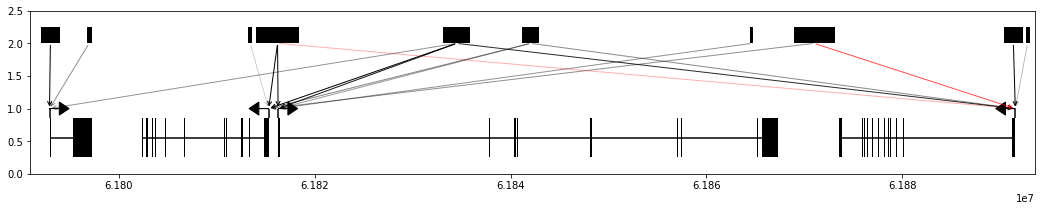

In [30]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores)

plt.savefig('FADS_locus__full_locus__connectogram.pdf')

plt.show()

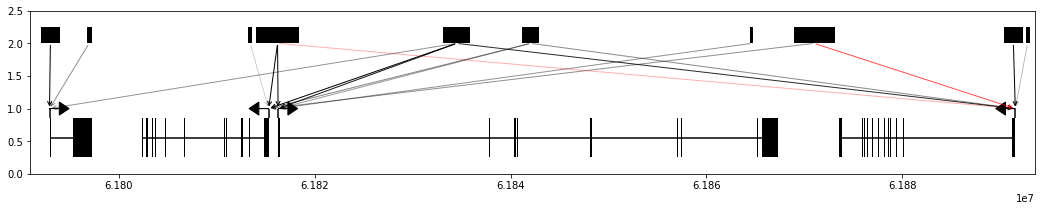

In [31]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores)
plt.show()

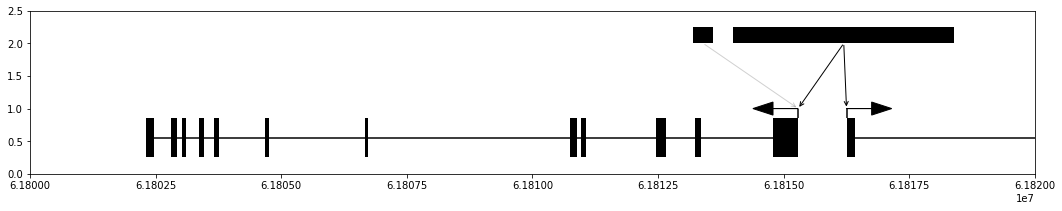

In [32]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [61800000,61820000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores, xlims=glims)

plt.savefig('FADS_locus__61800000_61820000__connectogram.pdf')

plt.show()

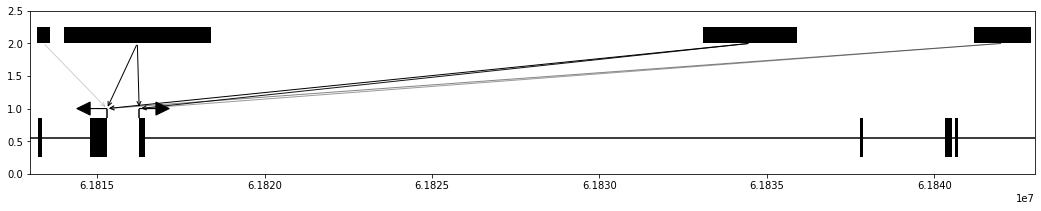

In [33]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [61813000,61843000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores, xlims=glims)

plt.savefig('FADS_locus__61813000_61843000__connectogram.pdf')

plt.show()

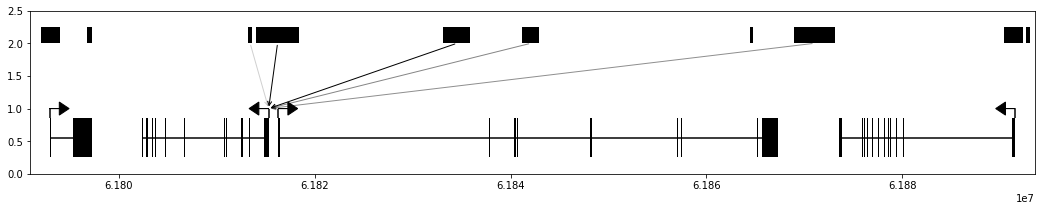

In [34]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores)

plt.savefig('FADS1__full_locus__connectogram.pdf')

plt.show()

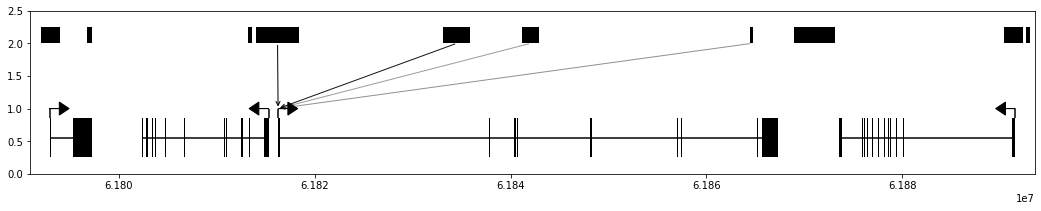

In [35]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores)

plt.savefig('FADS2__full_locus__connectogram.pdf')

plt.show()

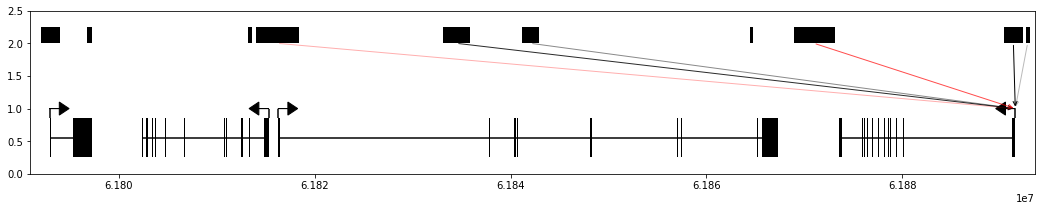

In [36]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores)

plt.savefig('FADS3__full_locus__connectogram.pdf')

plt.show()

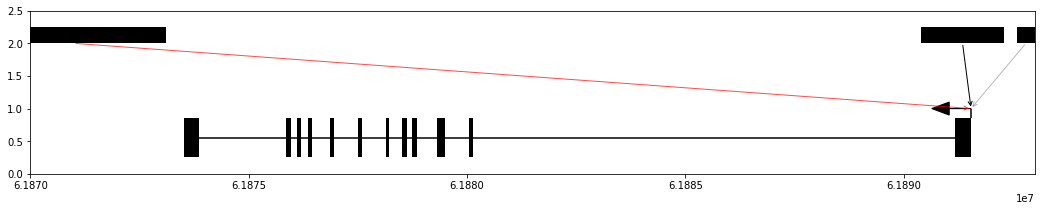

In [37]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [61870000,61893000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
#connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS1'], y_anchor=2.0, y_target=1.0, score_bed=FADS1_total_scores, xlims=glims)
#connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS2'], y_anchor=2.0, y_target=1.0, score_bed=FADS2_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FADS3'], y_anchor=2.0, y_target=1.0, score_bed=FADS3_total_scores, xlims=glims)
#connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores, xlims=glims)

plt.savefig('FADS_locus__61863000_61893000__connectogram.pdf')

plt.show()

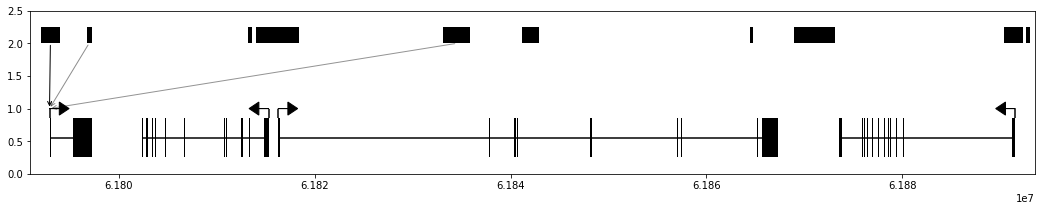

In [38]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['FEN1'], y_anchor=2.0, y_target=1.0, score_bed=FEN1_total_scores)

plt.savefig('FEN1__full_locus__connectogram.pdf')

plt.show()

# Effector directionality analysis

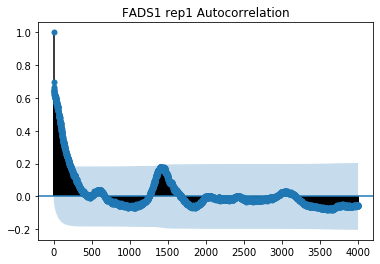

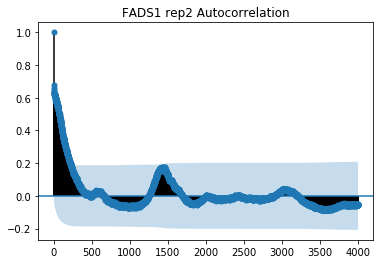

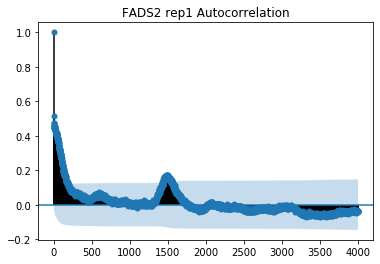

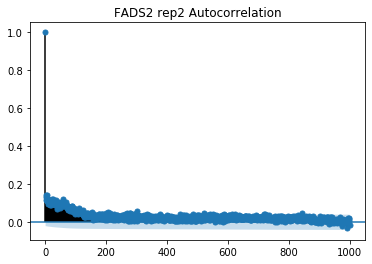

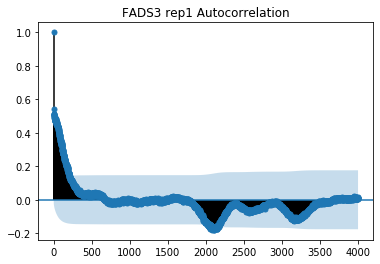

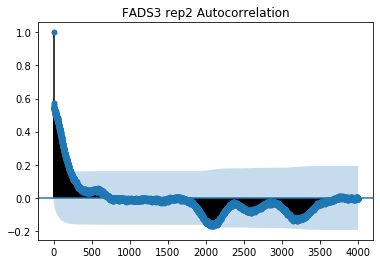

In [39]:
plot_acf( data['F1R1'], lags=4000, title='FADS1 rep1 Autocorrelation' )
plt.savefig('FADS1_rep1__autocorrelation.pdf')
plt.show()
plot_acf( data['F1R2'], lags=4000, title='FADS1 rep2 Autocorrelation' );
plt.savefig('FADS1_rep2__autocorrelation.pdf')
plt.show()
plot_acf( data['F2R1'], lags=4000, title='FADS2 rep1 Autocorrelation' );
plt.savefig('FADS2_rep1__autocorrelation.pdf')
plt.show()
plot_acf( data['F2R2'], lags=1000, title='FADS2 rep2 Autocorrelation' );
plt.savefig('FADS2_rep2__autocorrelation.pdf')
plt.show()
plot_acf( data['F3R1'], lags=4000, title='FADS3 rep1 Autocorrelation' );
plt.savefig('FADS3_rep1__autocorrelation.pdf')
plt.show()
plot_acf( data['F3R2'], lags=4000, title='FADS3 rep2 Autocorrelation' );
plt.savefig('FADS3_rep2__autocorrelation.pdf')
plt.show()


In [40]:
pos_strand = [ True if ':+' in x else False for x in data.index ]
neg_strand = [ True if ':-' in x else False for x in data.index ]

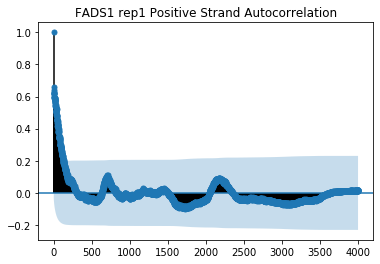

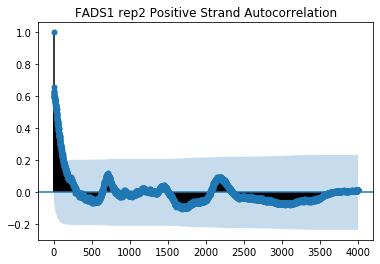

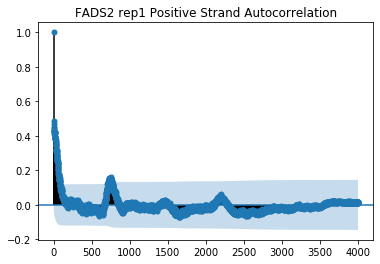

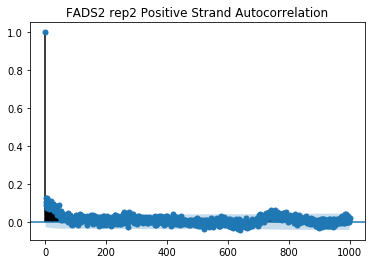

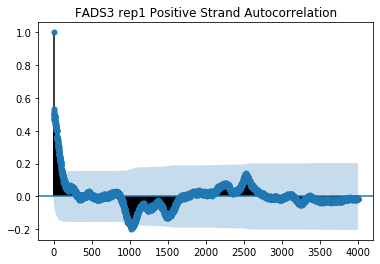

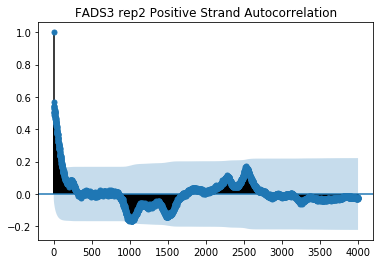

In [41]:
plot_acf( data.loc[pos_strand,'F1R1'], lags=4000, title='FADS1 rep1 Positive Strand Autocorrelation' )
plt.savefig('FADS1_rep1_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F1R2'], lags=4000, title='FADS1 rep2 Positive Strand Autocorrelation' );
plt.savefig('FADS1_rep2_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F2R1'], lags=4000, title='FADS2 rep1 Positive Strand Autocorrelation' );
plt.savefig('FADS2_rep1_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F2R2'], lags=1000, title='FADS2 rep2 Positive Strand Autocorrelation' );
plt.savefig('FADS2_rep2_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F3R1'], lags=4000, title='FADS3 rep1 Positive Strand Autocorrelation' );
plt.savefig('FADS3_rep1_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F3R2'], lags=4000, title='FADS3 rep2 Positive Strand Autocorrelation' );
plt.savefig('FADS3_rep2_pos__autocorrelation.pdf')
plt.show()


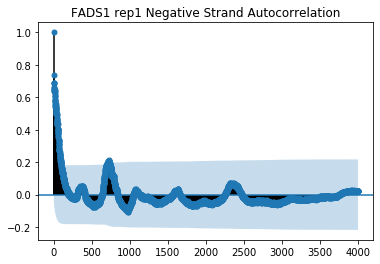

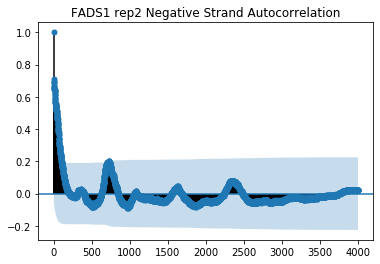

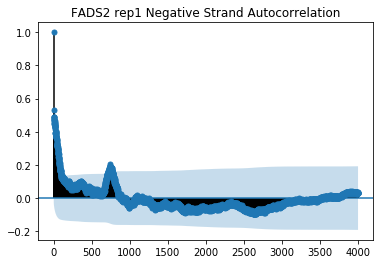

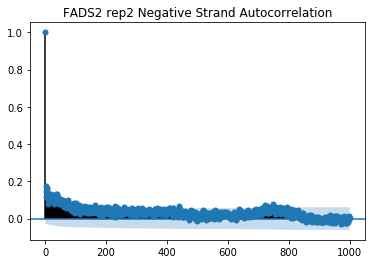

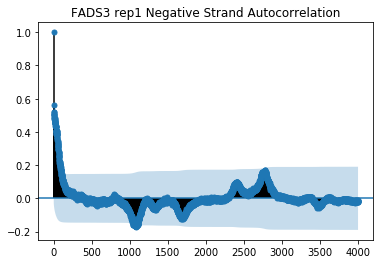

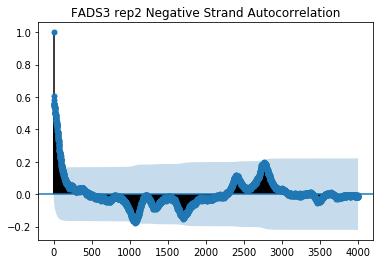

In [42]:
plot_acf( data.loc[neg_strand,'F1R1'], lags=4000, title='FADS1 rep1 Negative Strand Autocorrelation' )
plt.savefig('FADS1_rep1_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F1R2'], lags=4000, title='FADS1 rep2 Negative Strand Autocorrelation' );
plt.savefig('FADS1_rep2_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F2R1'], lags=4000, title='FADS2 rep1 Negative Strand Autocorrelation' );
plt.savefig('FADS2_rep1_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F2R2'], lags=1000, title='FADS2 rep2 Negative Strand Autocorrelation' );
plt.savefig('FADS2_rep2_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F3R1'], lags=4000, title='FADS3 rep1 Negative Strand Autocorrelation' );
plt.savefig('FADS3_rep1_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F3R2'], lags=4000, title='FADS3 rep2 Negative Strand Autocorrelation' );
plt.savefig('FADS3_rep2_neg__autocorrelation.pdf')
plt.show()


FADS1
5


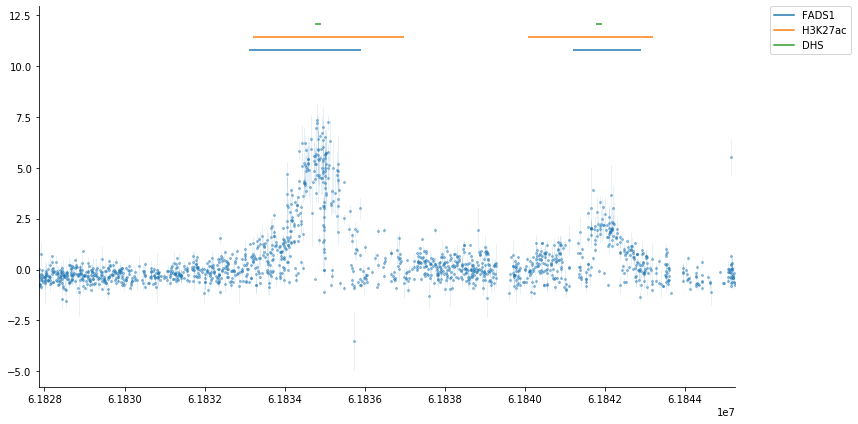

In [43]:
fig_h, ax_h = plot_combined_cutsites(np.array([[61827852,61845270]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','k27','DHS'])
fig_h.savefig('FADS_locus__61827852_61845270__noFEN1.pdf')

In [44]:
data['strand'] = [ x.split(':')[-1] for x in data.index ]

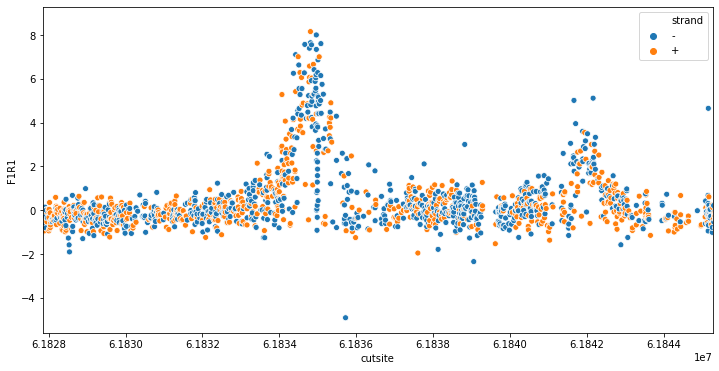

In [45]:
fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(data=data,x='cutsite',y='F1R1',hue='strand')
ax.set_xlim([61827852,61845270])
fig.savefig('FADS_locus__strandeffectsFADS1.pdf')
plt.show()

# Subsetting analysis

In [46]:
S0R1_fn = '../data/FASTQ/FADS1_rep8detailed.txt'
S1R1_fn = 'subset_10__FADS1_rep8detailed.txt'
S2R1_fn = 'subset_20__FADS1_rep8detailed.txt'
S3R1_fn = 'subset_30__FADS1_rep8detailed.txt'
S4R1_fn = 'subset_40__FADS1_rep8detailed.txt'
S5R1_fn = 'subset_50__FADS1_rep8detailed.txt'
S6R1_fn = 'subset_60__FADS1_rep8detailed.txt'
S7R1_fn = 'subset_70__FADS1_rep8detailed.txt'
S8R1_fn = 'subset_80__FADS1_rep8detailed.txt'
S9R1_fn = 'subset_90__FADS1_rep8detailed.txt'

fn_list = [S0R1_fn,S1R1_fn,S2R1_fn,S3R1_fn,S4R1_fn,
           S5R1_fn,S6R1_fn,S7R1_fn,S8R1_fn,S9R1_fn]

exp_ids = ['S0R1','S1R1','S2R1','S3R1','S4R1',
           'S5R1','S6R1','S7R1','S8R1','S9R1']

fullinfo= [("Sub00",1), ("Sub10",1), ("Sub20",1), ("Sub30",1), ("Sub40",1), 
           ("Sub50",1), ("Sub60",1), ("Sub70",1), ("Sub80",1), ("Sub90",1)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [47]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [49]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [50]:
plus_offsets = [152, 147]
minus_offsets= [146, 153]
activ_area= np.array([ [ int(coord.split(':')[1].split('-')[1]) - plus_offsets[0],
                         int(coord.split(':')[1].split('-')[1]) + plus_offsets[1] ] if coord.split(':')[2] == '+' 
                       else [ int(coord.split(':')[1].split('-')[1]) - minus_offsets[0],
                              int(coord.split(':')[1].split('-')[1]) + minus_offsets[1] ]
                       for coord in data.index ])
activ_area= np.concatenate([np.full(shape=(activ_area.shape[0],1),fill_value='chr11',dtype=np.object),activ_area],axis=1)

In [51]:
activ_area

array([['chr11', 61788400, 61788699],
       ['chr11', 61788403, 61788702],
       ['chr11', 61788430, 61788729],
       ...,
       ['chr11', 61897005, 61897304],
       ['chr11', 61897008, 61897307],
       ['chr11', 61897004, 61897303]], dtype=object)

In [52]:
sorted(glob.glob('191125_subset/*__mergedPeaks.bed'))

['191125_subset/subset_00__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_10__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_20__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_30__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_40__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_50__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_60__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_70__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_80__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_90__FADS1_rep8detailed__mergedPeaks.bed']

In [53]:
test_peaks = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end']) for fn in sorted(glob.glob('191125_subset/*__mergedPeaks.bed')) ]
print(len(test_peaks))
extra_feat = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end'],usecols=[0,1,2]) for fn in ['../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed','../data/DNASE_peaks_replicated.bed'] ]
[ test_peaks.append( feat.loc[ feat['chr'] == 'chr11' ,:] ) for feat in extra_feat ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print(len(test_peaks))
for exp_id, peaks_idx in zip(['S0R1','S1R1','S2R1','S3R1','S4R1','S5R1','S6R1','S7R1','S8R1','S9R1','k27','DHS'],range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


10
12


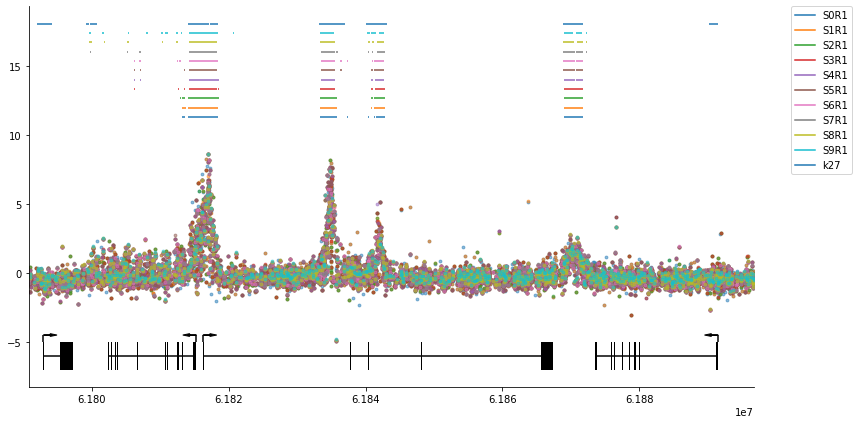

In [54]:
fig_h, ax_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['S0R1','S1R1','S2R1','S3R1','S4R1','S5R1','S6R1','S7R1','S8R1','S9R1','k27'])

draw_genes_from_gff(ax_h, gff)

fig_h.savefig('FADS_locus__subsettingFADS1.pdf')



In [55]:
strong_peaks = test_peaks.loc[test_peaks['assay']=='Sub00'.format(i),('chr','start','end')].values
allsub_peaks = test_peaks[test_peaks['assay'].str.contains('Sub')][~test_peaks['assay'].str.contains('Sub00')]
allsub_peaks = merge_bed(allsub_peaks.loc[:,('chr','start','end')])
slicer = np.vstack([ check_overlap([list(a_peak[1:3])],
                                   allsub_peaks.loc[:,('start','end')].values
                                  ) 
                     for a_peak in strong_peaks ]).any(axis=0)
weak_peaks   = allsub_peaks[ ~slicer ].values

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [56]:
strong_peaks = test_peaks.loc[test_peaks['assay']=='Sub00'.format(i),('chr','start','end')].values
maxsub_peaks = test_peaks.loc[test_peaks['assay']=='Sub90'.format(i),('chr','start','end')].values
weak_peaks   = maxsub_peaks[ maxsub_peaks[:,2] < strong_peaks[0,1] ]
weak_peaks

array([['chr11', 61799644, 61799844],
       ['chr11', 61800244, 61800344],
       ['chr11', 61801444, 61801844],
       ['chr11', 61805244, 61805444],
       ['chr11', 61807944, 61808244],
       ['chr11', 61810144, 61810344],
       ['chr11', 61810744, 61811144],
       ['chr11', 61812344, 61812544]], dtype=object)

In [57]:
strong_filter = [ sum(check_overlap(interval[1:3].astype(int), strong_peaks[:,1:3])) > 0 for interval in activ_area ]
weak_filter   = [ sum(check_overlap(interval[1:3].astype(int), weak_peaks[:,1:3])) > 0 for interval in activ_area ]
noPeak_filter = [ sum(check_overlap(interval[1:3].astype(int), weak_peaks[:,1:3])) == 0 for interval in activ_area ]

In [58]:
guide_effect_ = np.concatenate( [data[strong_filter].loc[:,'S0R1'].values, 
                                 data[weak_filter].loc[:,'S0R1'].values,
                                 data[noPeak_filter].loc[:,'S0R1'].values] )
strength_tag_ = np.concatenate( [np.full(shape=sum(strong_filter),fill_value='strong'), 
                                 np.full(shape=sum(weak_filter),fill_value='weak'),
                                 np.full(shape=sum(noPeak_filter),fill_value='inactive')] )

In [59]:
tidy_strength = pd.DataFrame({'activity': guide_effect_, "peak_strength": strength_tag_})

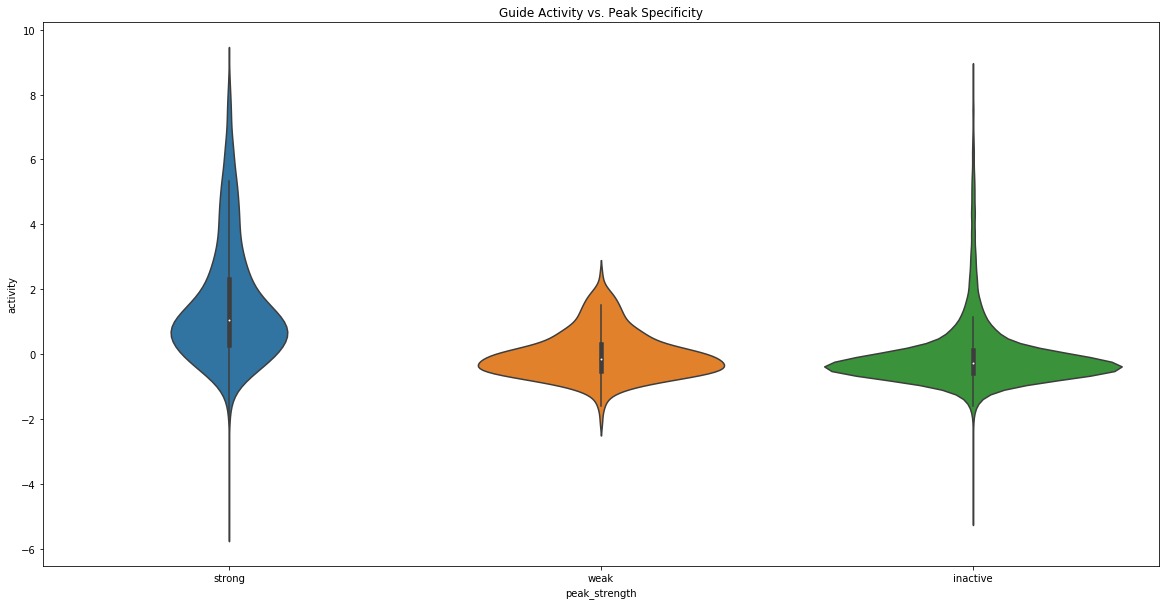

In [60]:
plt.figure(figsize=(20,10))
sns.violinplot(x='peak_strength',y='activity',data=tidy_strength, showfliers = False) \
  .set_title("Guide Activity vs. Peak Specificity");

plt.savefig('guide_score_in_peak_subsets.pdf')

In [61]:
overlap_with_k27ac = []
for i in range(10):
    hold_k27 = test_peaks.loc[test_peaks['assay']=='H3K27ac',('chr','start','end')].values
    hold_sub = test_peaks.loc[test_peaks['assay']=='Sub{}0'.format(i),('chr','start','end')].values
    total_sub_nt = sum(hold_sub[:,2] - hold_sub[:,1])
    inter_sub_nt = sum(intersect_bed3(hold_sub, hold_k27).loc[:,'end'] - intersect_bed3(hold_sub, hold_k27).loc[:,'start'])
    print("{}/{}={}".format(inter_sub_nt,total_sub_nt,inter_sub_nt/total_sub_nt))
    overlap_with_k27ac.append([inter_sub_nt,total_sub_nt])
    

11458/12200=0.9391803278688524
11458/12200=0.9391803278688524
11358/12400=0.9159677419354839
11030/11700=0.9427350427350427
10650/11400=0.9342105263157895
10882/11600=0.9381034482758621
10850/12200=0.889344262295082
10782/12000=0.8985
10545/11800=0.8936440677966102
10499/12900=0.813875968992248


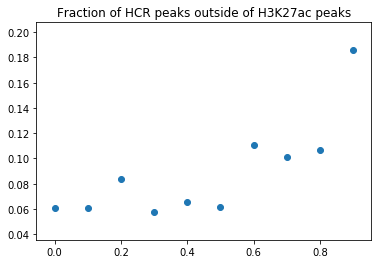

In [62]:
plt.scatter( np.arange(10)/10, [ (y-x)/y for x,y in overlap_with_k27ac ] )

plt.title("Fraction of HCR peaks outside of H3K27ac peaks")

plt.savefig("HCR_Histone_peak_inclusion_w_subsetting.pdf")

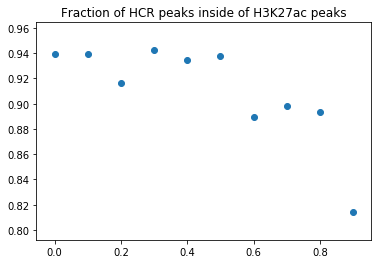

In [63]:
plt.scatter( np.arange(10)/10, [ x/y for x,y in overlap_with_k27ac ] )

plt.title("Fraction of HCR peaks inside of H3K27ac peaks")
plt.savefig("HCR_Histone_peak_exclusion_w_subsetting.pdf")

In [64]:
hold_k27 = test_peaks.loc[test_peaks['assay']=='H3K27ac',('chr','start','end')].values
hold_s10 = test_peaks.loc[test_peaks['assay']=='Sub10',('chr','start','end')].values

In [65]:
hold_k27[ (hold_k27[:,2] > 61815235) & (hold_k27[:,1] < 61871385) ]

array([['chr11', 61813997, 61817089],
       ['chr11', 61817207, 61818398],
       ['chr11', 61833216, 61836978],
       ['chr11', 61840084, 61843199],
       ['chr11', 61868883, 61871778]], dtype=object)

In [66]:
hold_s10

array([['chr11', 61813200, 61813700],
       ['chr11', 61814000, 61818400],
       ['chr11', 61833300, 61835900],
       ['chr11', 61840800, 61841000],
       ['chr11', 61841200, 61842800],
       ['chr11', 61868500, 61868600],
       ['chr11', 61869000, 61871800]], dtype=object)

In [67]:
sum(intersect_bed3(hold_s10, hold_k27).loc[:,'end'] - intersect_bed3(hold_s10, hold_k27).loc[:,'start'])

11458

In [68]:
sum(hold_s10[:,2] - hold_s10[:,1])

12200